In [1]:
%matplotlib inline



# Sleep stage classification from polysomnography (PSG) data
### PSG(Polysomnography) 데이터를 통한 수면 단계 분류

<div class="alert alert-info"><h4>Note</h4><p>This code is taken from the analysis code used in
          :footcite:`ChambonEtAl2018`. If you reuse this code please consider
          citing this work.</p></div>

This tutorial explains how to perform a toy polysomnography analysis that
answers the following question:

- 이 튜토리얼에서는 장난감 수면다원검사(PSG : polysomnography)데이터를 활용하여 수면단계분류를 수행하는 모델을 만들어 봅니다.

.. important:: Given two subjects from the Sleep Physionet dataset
               :footcite:`KempEtAl2000,GoldbergerEtAl2000`, namely
               *Alice* and *Bob*, how well can we predict the sleep stages of
               *Bob* from *Alice's* data?
- ..중요: Sleep Physionet 데이터 세트의 두 가지 피사체가 주어집니다: footcite:KempEtAl2000, GoldbergerEtAl2000, 즉 Alice와 Bob은 Alice의 데이터에서 Bob의 수면 단계를 얼마나 잘 예측할 수 있을까요?

This problem is tackled as supervised multiclass classification task. The aim
is to predict the sleep stage from 5 possible stages for each chunk of 30
seconds of data.
- 이 문제는 감독되는 다중 클래스 분류 작업으로 처리되며, 목적은 30초 데이터의 각 청크에 대해 가능한 5단계의 수면 단계를 예측하는 것이다.



In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Stanislas Chambon <stan.chambon@gmail.com>
#          Joan Massich <mailsik@gmail.com>
#
# License: BSD Style.

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

ModuleNotFoundError: No module named 'mne'

## Load the data

Here we download the data from two subjects and the end goal is to obtain
:term:`epochs` and its associated ground truth.
- 여기서 우리는 두 가지 주제에서 데이터를 다운로드하며 최종 목표는 epochs 및 관련 실제 정보를 얻는 것이다.

MNE-Python provides us with
:func:`mne.datasets.sleep_physionet.age.fetch_data` to conveniently download
data from the Sleep Physionet dataset
:footcite:`KempEtAl2000,GoldbergerEtAl2000`.
Given a list of subjects and records, the fetcher downloads the data and
provides us for each subject, a pair of files:

- MNE-Python은 Sleep Physionet 데이터 세트에서 데이터를 편리하게 다운로드할 수 있는 데이터를 제공한다
- 제목과 레코드의 목록이 주어지면, 페처는 데이터를 다운로드하고 각 제목에 대해 우리에게 아래와 같은 파일 한 쌍을 제공한다

* ``-PSG.edf`` containing the polysomnography. The :term:`raw` data from the
  EEG helmet,
* ``-Hypnogram.edf`` containing the :term:`annotations` recorded by an
  expert.  

- 1) -PSG.edf 는 수면다원검사를 통해 수집된 raw 정보(EEG 헬멧 사용)
- 2) -Hypnogram.edf 는 전문가(수면기사)에 의해 기록된 주석 정보

    - 해당 주석은 시작, 기간 및 문자열 설명으로 정의됩니다. 여기에는 실험에 대한 정보뿐만 아니라 잘못된 데이터 세그먼트, 수면 점수, 수면 이벤트 (스핀들, K- 복합체) 등과 같이 사람이 표시 한 신호에 대한 세부 정보도 포함될 수 있습니다. Annotations개체는 여러 주석의 컨테이너입니다. Annotations해당 객체 클래스의 API 및 해당 객체 를 조작하는 방법에 대한 자습서는 아래 주석 함수 페이지를 참조 하십시오 .
    - mne.Annotations 공식문서https://mne.tools/stable/generated/mne.Annotations.html#mne.Annotations
    
Combining these two in a :class:`mne.io.Raw` object then we can extract
:term:`events` based on the descriptions of the annotations to obtain the
:term:`epochs`

- 이 둘을 결합하면 주석의 설명을 기반으로 이벤트를 추출하여 epochs을 얻을 수 있다.
- epochs란 원시 연속 데이터에서 추출 된 동일한 길이의 데이터 범위를 말하며 일반적으로 자극 이벤트나 피험자의 반응을 중심으로 추출되며 때때로 순차적이거나 겹치는 epoch가 추출 된다.
### Read the PSG data and Hypnograms to create a raw object
#### PSG 데이터 읽기 및 raw object(관측값)으로 부터 수면단계그래프 생성하기
- Hypnograms란?
    - 다형성의 형태로 수면 단계를 나타내는 그래프
    - 수면 기간 동안 뇌파에서 뇌파 활동의 기록을 제시하는 방법으로 개발 됨.
    - 수면 사이클 동안 빠른 안구 운동 수면 (렘수면) 과 비-렘수면 단계를 나타냄.


Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from C:\Users\ixxxxu\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


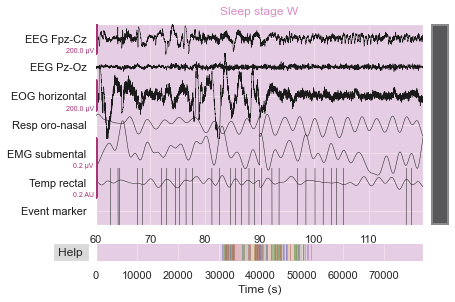

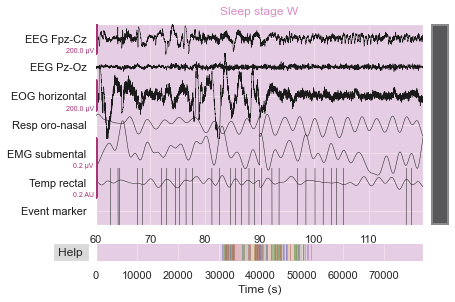

In [20]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])


'''
EOG :안전위도 검사 
눈의 위아래 혹은 좌우에 전극을 설치하여 안구 움직임을 기록한 것
(데이터셋에서는 안구의 수평움직임을 추적)
Resp oro-nasal: 호흡
EMG submental: 근전도 기록
Temp rectal: 체온
Event marker :기타 이벤트 기록

'''


mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'resp',
           'EMG submental': 'emg',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_train = mne.io.read_raw_edf(alice_files[0])# 앨리스(훈련데이터)_로우파일 불러오기
annot_train = mne.read_annotations(alice_files[1]) #앨리스(훈련데이터)_주석파일 불러오기

raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping)

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset

# 데이터 플롯
# 스케일링을 수동으로 선택하여 동시 시각화 가능
# 이 특정 데이터 세트의 다양한 채널 유형 설정


# start = 표시할 초기 시간 (플로팅 된후 동적으로 변경 될 수 있음), float
# duration = 표시할 타임 스텝, float
# scalings = 추척에 대한 배율 조정 요소 dict
#(scalings == 'auto'일 경우 모든 크기 조정 필드가 'auto' 로 설정됨)
'''
scalings 기본값
dict(mag=1e-12, grad=4e-11, eeg=20e-6, eog=150e-6, ecg=5e-4,
     emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1, chpi=1e-4, whitened=1e2)
'''
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

### Extract 30s events from annotations
### 주석으로부터 30초 이벤트 추출

The Sleep Physionet dataset is annotated using
`8 labels <physionet_labels_>`_:
Wake (W), Stage 1, Stage 2, Stage 3, Stage 4 corresponding to the range from
light sleep to deep sleep, REM sleep (R) where REM is the abbreviation for
Rapid Eye Movement sleep, movement (M), and Stage (?) for any none scored
segment.

Sleep Physionet 데이터 세트에는 8개의 라벨 <physionet_labels_>_: Wake(W), 1단계, 2단계, 3단계, 4단계(Stage 4), REM(R)을 사용하여 주석이 달렸고 여기서 REM은 Rapid Eye Movement(M)의 약자이다.

We will work only with 5 stages: Wake (W), Stage 1, Stage 2, Stage 3/4, and
REM sleep (R). To do so, we use the ``event_id`` parameter in
:func:`mne.events_from_annotations` to select which events are we
interested in and we associate an event identifier to each of them.

다음 5단계에서만 작업할 수 있다. 웨이크(W), 1단계, 2단계, 3/4단계 및 REM 슬립(R)입니다. 이를 위해 `mne.events_from_anotations`에서 `event_id` 매개 변수를 사용하여 관심 있는 이벤트를 선택하고 각 이벤트에 이벤트 식별자를 연결한다

- 수면기(Sleep Stages)의 정의
    - 수면 상태를 뇌파(EEG), 근전도(EMG), 안전도 (EOG) 소견에 따라서 수면1기, 수면2기, 수면3기, 수면4기, REM 수면기로 구분하고 이 외에 각성 상태(wakefulness, Stage W), 수면 중 움직임(movement time,MT)로 구분한다.
M T )으로 구분한다
- 특정 이벤트에 대한 식별 -> 패턴 인식 -> 판독 및 진단 을 위해서 모델 스스로 학습하는 과정이 필요 -> 보상을 얻기 위해 모델이 스스로 전문가(Expert Agent)의 행동을 사용하는 역강화학습을 적용해볼 수 있을듯
- 기계학습 방식을 통해 패턴인식을 하는것이 현실적이고, 사용자의 여러 특성을 고려한 세밀한 설정이 필요

Moreover, the recordings contain long awake (W) regions before and after each
night. To limit the impact of class imbalance, we trim each recording by only
keeping 30 minutes of wake time before the first occurrence and 30 minutes
after the last occurrence of sleep stages.

또한, 기록에는 각 기록 전후의 긴 깨어 있는 (W) 영역이 밤 수면의 전과 후에 포함되어 있다.
클래스의 불균형의 영향을 제한하기 위해 각 녹음을 다음과 같이 분리
- 첫 번째 각성 전 30 분 
- 수면 단계의 마지막 발생 후 30 분

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


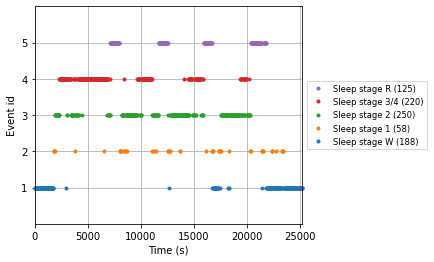

In [4]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
# 잠자기 전에 마지막 30 분 깨우기 이벤트를 유지하고 이후 처음 30 분 깨우기 이벤트를 유지#
#raw 데이터에 대한 수면 및 주석 재정의

annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
# 3 단계와 4 단계를 통합하는 새로운 event_id를 만듭니다
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
# plot 이벤트 시각화
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# keep the color-code for further plotting
# 추가 플로팅을 위해 색상 코드 유지
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Create Epochs from the data based on the events found in the annotations
#### 주석에서 찾은 이벤트를 기반으로 데이터에서 Epoch를 생성합니다.


In [5]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125
 'Sleep stage W': 188>


### Applying the same steps to the test data from Bob
#### Bob(테스트 데이터)의 데이터에 동일한 단계 적용



In [6]:
raw_test = mne.io.read_raw_edf(bob_files[0])
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
raw_test.set_channel_types(mapping)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from C:\Users\ixxxxu\mne_data\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170
 'Sleep stage W': 157>


## Feature Engineering
#### 특성공학
Observing the power spectral density (PSD) plot of the :term:`epochs` grouped
by sleeping stage we can see that different sleep stages have different
signatures. These signatures remain similar between Alice and Bob's data.

수면 단계별로 그룹화된 `epochs`의 전력 스펙트럼 밀도(PSD) 그림을 관찰하면 서로 다른 수면 단계의 특징이 있음을 알 수 있다. 이 특징들은 앨리스와 밥의 데이터 사이에 유사한 패턴을 보인다.

The rest of this section we will create EEG features based on relative power
in specific frequency bands to capture this difference between the sleep
stages in our data.

이 섹션의 나머지 부분에서는 상대적인 전력을 바탕으로 EEG 특성을 만든다.
이를 통해 특정 주파수대에서 이 수면의 차이를 포착한다.

Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 562 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS w

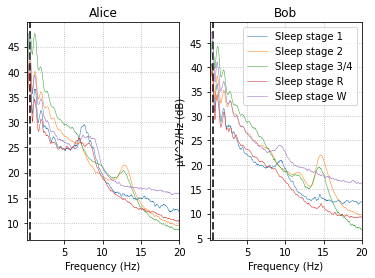

In [7]:
# visualize Alice vs. Bob PSD by sleep stage. 
#PSD = power spectral density -> 해당 신호를 구성하는 주파수 성분으로의 전력 분포 설명
# 수면 단계별로 Alice vs. Bob PSD를 시각화합니다.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                               fmin=0.1, fmax=20., show=False,
                               average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax2.set(ylabel='µV^2/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.show()

### Design a scikit-learn transformer from a Python function
#### Python 함수에서 scikit-learn transformer 설계

We will now create a function to extract EEG features based on relative power
in specific frequency bands to be able to predict sleep stages from EEG
signals.

상대적인 파워를 바탕으로 뇌파의 특징을 추출하는 기능을 작성합니다.
뇌파에서 수면 단계를 예측할 수 있는 특정 주파수대에서 신호를 송신합니다.


In [8]:
def eeg_power_band(epochs):
    """
    EEG relative power band feature extraction.
    EEG (특정 주파수 대역에서 활동량) 특성 추출.


    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.
    이 함수는``mne.Epochs ''개체를 사용하여 scikit-learn에서 호환되는 특정 주파수 대역의 상대 전력
    EEG 특성을 생성합니다.
    
    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    # 특정 주파수 대역

    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    # PSD 정규화

    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

## Multiclass classification workflow using scikit-learn
#### scikit-learn을 사용한 다중 클래스 분류 워크 플로우

To answer the question of how well can we predict the sleep stages of Bob
from Alice's data and avoid as much boilerplate code as possible, we will
take advantage of two key features of sckit-learn:
`Pipeline`_ , and `FunctionTransformer`_.

Alice의 데이터에서 Bob의 수면 단계를 얼마나 잘 예측하고 가능한 한 많은 상용구 코드를 피할 수 있는지에 대한 질문에 답하기 위해 sckit-learn의 두 가지 주요 기능인 `Pipeline`_ ,와 `FunctionTransformer`_를 활용합니다.

Scikit-learn pipeline composes an estimator as a sequence of transforms
and a final estimator, while the FunctionTransformer converts a python
function in an estimator compatible object. In this manner we can create
scikit-learn estimator that takes :class:`mne.Epochs` thanks to
``eeg_power_band`` function we just created.

Scikit-learn 파이프 라인은 추정기를 변환 시퀀스 및 최종 추정기로 구성하는 반면 FunctionTransformer는 추정기와 호환되는 객체에서 파이썬 함수를 변환합니다. 이런 식으로 방금 만든 `eeg_power_band` 함수를 통해 : class : `mne.Epochs`를 사용하는 scikit-learn 추정기를 만들 수 있습니다.



In [9]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Loading data for 1103 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Accuracy score: 0.6699909338168631


In short, yes. We can predict Bob's sleeping stages based on Alice's data.
 Alice의 데이터를 기반으로 Bob의 수면 단계를 예측 가능

### Further analysis of the data
#### 데이터 추가 분석

We can check the confusion matrix or the classification report.
혼동 행렬이나 분류 보고서를 추가로 확인할 수 있다



In [10]:
print(confusion_matrix(y_test, y_pred))

[[156   0   1   0   0]
 [ 67  27   5   3   7]
 [ 53  51 401  33  24]
 [  0   0   5 100   0]
 [ 52  45  18   0  55]]


In [14]:
result = confusion_matrix(y_test, y_pred)

In [16]:
import seaborn as sns 
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas import DataFrame 
%matplotlib inline 
sns.set(font_scale=1)

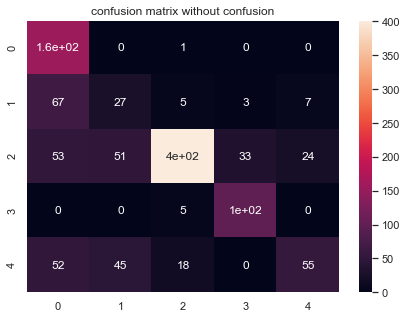

In [18]:
plt .figure(figsize = (7,5)) 
plt.title('confusion matrix without confusion') 
sns.heatmap(result, annot=True);

In [11]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.48      0.99      0.64       157
  Sleep stage 1       0.22      0.25      0.23       109
  Sleep stage 2       0.93      0.71      0.81       562
Sleep stage 3/4       0.74      0.95      0.83       105
  Sleep stage R       0.64      0.32      0.43       170

       accuracy                           0.67      1103
      macro avg       0.60      0.65      0.59      1103
   weighted avg       0.73      0.67      0.67      1103



## Exercise

Fetch 50 subjects from the Physionet database and run a 5-fold
cross-validation leaving each time 10 subjects out in the test set.

Physionet 데이터베이스에서 50 명의 피험자를 가져 와서 5 -fold 교차검증 수행
테스트 세트에서 10 명의 피험자가 나올 때마다 교차 검증.

## References
.. footbibliography::

